In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import numpy as np

# Ejercicio_2_ID_MAP

## Introducción al Análisis Exploratorio de Datos

En el contexto de la biología y la medicina de precisión, el estudio de las respuestas celulares a diferentes compuestos es fundamental para entender la variabilidad biológica y el impacto de los tratamientos a nivel molecular. Este análisis se vuelve especialmente relevante cuando se trata de datos de expresión génica en células individuales, ya que permite identificar cómo distintas células responden a perturbaciones químicas y cómo estas respuestas varían entre diferentes tipos celulares y contextos biológicos.

### Importancia del Problema

El objetivo de este problema es explorar y predecir las respuestas de las células mononucleares de sangre periférica (PBMC) humanas a una serie de compuestos seleccionados. Estos compuestos fueron elegidos del Mapa de conectividad de la Biblioteca de firmas celulares basadas en redes integradas (LINCS) y aplicados a células humanas sanas durante 24 horas. Dada la relevancia de las PBMC en enfermedades inmunológicas y otras condiciones.

### Descripción del Conjunto de Datos

El conjunto de datos utilizado en este análisis fue generado específicamente para este ejericicio. Se seleccionaron 144 compuestos del conjunto de datos de LINCS, y se midieron los perfiles de expresión génica en células individuales después de 24 horas de tratamiento en PBMC humanas provenientes de tres donantes sanos. Las células PBMC, que incluyen tipos celulares como células T, células B, células mieloides y células NK, fueron elegidas por su relevancia como tejido primario en la enfermedad y su disponibilidad comercial con el consentimiento adecuado para la publicación pública.

Además de los datos de expresión génica, también se recolectaron mediciones conjuntas de la accesibilidad de la cromatina y el ARNsc mediante el ensayo Multiome 10x para cada donante al inicio del estudio. Este enfoque multiómico pretende enriquecer el contexto biológico del estudio, proporcionando una base para entender cómo diferentes tipos de células responden a las perturbaciones y cómo estas respuestas pueden ser moduladas por la accesibilidad de la cromatina.

### Objetivo del (EDA)

El análisis exploratorio de datos que realizamos tiene como objetivo:

1. **Comprender la distribución de las variables clave**: incluyendo el tipo de célula (`cell_type`), el nombre del compuesto (`sm_name`) y los valores de expresión diferencial de genes.
2. **Identificar patrones en los datos**: mediante la visualización de la frecuencia de diferentes tipos de células y compuestos, así como la exploración de posibles relaciones entre las variables.
3. **Detectar outliers y datos faltantes**: lo que es crucial para garantizar la calidad del modelo predictivo.

### Fuentes de Datos

Los datos utilizados provienen del experimento diseñado para esta ejericicio de la pag kaggle, que incluye mediciones de expresión génica de células individuales tratadas con compuestos seleccionados del conjunto de datos LINCS. Adicionalmente, se incorporaron datos multiómicos para enriquecer el contexto biológico de cada donante y tipo celular al inicio del estudio.

Este conjunto de datos, junto con las técnicas de análisis exploratorio, permite una comprensión más profunda de la variabilidad biológica.


# Data frames usados para EDA

In [2]:
df_dataobs = pd.read_csv('documentos_ejercicio2.2\\adata_obs_meta.csv')
print(df_dataobs.head())
print(df_dataobs.size)
print("---------------------------")
df_map = pd.read_csv('documentos_ejercicio2.2\\id_map.csv')
print(df_map.head())
print(df_map.size)

             obs_id  library_id plate_name well row  col cell_id donor_id  \
0  000006a87ba75b72   library_4    plate_4   F7   F    7    PBMC  donor_2   
1  0000233976e3cd37   library_0    plate_3   D4   D    4    PBMC  donor_1   
2  0001533c5e876362   library_2    plate_0  B11   B   11    PBMC  donor_0   
3  00022f989630d14b  library_35    plate_2   E6   E    6    PBMC  donor_0   
4  0002560bd38ce03e  library_22    plate_4   B6   B    6    PBMC  donor_2   

            cell_type sm_lincs_id      sm_name  \
0        T cells CD4+    LSM-4944     MLN 2238   
1        T cells CD4+   LSM-46203   BMS-265246   
2  T regulatory cells   LSM-45663  Resminostat   
3        T cells CD4+   LSM-43216       FK 866   
4        T cells CD4+    LSM-1099    Nilotinib   

                                              SMILES  dose_uM  timepoint_hr  \
0      CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O      1.0            24   
1        CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12      1.0            24   

**Selección de Bases de Datos para EDA**

Del conjunto de bases de datos disponibles en el ejercicio, decidimos enfocarnos en las siguientes:

1. **`adata_obs_meta.csv`**: Esta base de datos contiene observaciones que consideramos esenciales para entender el problema en estudio, ya que ofrece detalles que permiten una exploración más profunda y contextualizada de las variables clave.

2. **`id_map.csv`**: Esta base de datos es complementaria a la base de datos que usaremos en para nuestro modelo, proporcionando un mapeo de identificadores que facilita la integración de información relevante.


# Data frame a usar para Modelo

In [3]:
df_parqdtra = pd.read_parquet('documentos_ejercicio2.2\\de_train.parquet')
print(df_parqdtra.head())
print(df_parqdtra.size)

            cell_type             sm_name sm_lincs_id  \
0            NK cells        Clotrimazole    LSM-5341   
1        T cells CD4+        Clotrimazole    LSM-5341   
2        T cells CD8+        Clotrimazole    LSM-5341   
3  T regulatory cells        Clotrimazole    LSM-5341   
4            NK cells  Mometasone Furoate    LSM-3349   

                                              SMILES  control      A1BG  \
0             Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1    False  0.104720   
1             Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1    False  0.915953   
2             Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1    False -0.387721   
3             Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1    False  0.232893   
4  C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...    False  4.290652   

   A1BG-AS1       A2M   A2M-AS1     A2MP1  ...      ZUP1      ZW10    ZWILCH  \
0 -0.077524 -1.625596 -0.144545  0.143555  ... -0.227781 -0.010752 -0.023881   
1 -0.884380  0.371834 -0.081677 -0.498266  ...

**Datos Fundamentales para Modelos de Machine Learning**

El conjunto de datos cargado desde `df_parqdtra` (`/content/de_train.parquet`) contiene la información necesaria para entrenar nuestros modelos de machine learning. Este dataset fue seleccionado porque incluye todas nuestras variables "target", lo cual es esencial para desarrollar modelos predictivos robustos y precisos.

Además, `df_parqdtra` incluye las características que mencionamos en nuestra introducción, asegurando que nuestros modelos utilicen los patrones necesarios para realizar predicciones efectivas.

# EDA

# Data frame de "adata_obs_meta"

In [4]:
df_dataobs.tail()

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
240085,ffff28f274e983df,library_27,plate_0,G12,G,12,PBMC,donor_0,NK cells,LSM-3349,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,1.0,24,False
240086,ffff32893af5befb,library_31,plate_4,E7,E,7,PBMC,donor_2,T cells CD4+,LSM-2287,Midostaurin,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,1.0,24,False
240087,ffff6c3e0a7b05ad,library_38,plate_1,C5,C,5,PBMC,donor_2,NK cells,LSM-45786,BAY 87-2243,Cc1cc(-c2nc(-c3ccc(OC(F)(F)F)cc3)no2)nn1Cc1ccn...,1.0,24,False
240088,ffff8e571c7e8cb0,library_28,plate_5,B1,B,1,PBMC,donor_1,B cells,LSM-43181,Belinostat,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,0.1,24,True
240089,ffffe67500d95d8d,library_9,plate_3,E1,E,1,PBMC,donor_1,Myeloid cells,LSM-43181,Belinostat,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,0.1,24,True


### Descripción del Archivo `adata_obs_meta.csv`

- **`library_id`**: Un identificador único para cada biblioteca, correspondiente a una medición realizada en muestras agrupadas de cada fila de la placa. Todas las células en los pocillos de la misma fila de la misma placa compartirán el mismo identificador de biblioteca.
  
- **`plate_name`**: Identificación única para todas las muestras de la misma placa.
  
- **`well`**: La ubicación del pocillo de la muestra en cada placa (esto es estándar en los experimentos con placas de 96 pocillos). Es una concatenación de filas y columnas.
  
- **`row`**: Fila de la placa de la que proviene la muestra.
  
- **`col`**: Columna de la placa de la que proviene la muestra.
  
- **`donor_id`**: Identifica la fuente donante de la muestra, una de tres posibles.
  
- **`cell_type`**: Tipo de célula anotado para cada célula en función de la expresión de ARN. Coincide con el `cell_type` en el archivo `de_train.parquet`.
  
- **`cell_id`**: Incluido para mantener la coherencia con los metadatos del Mapa de Conectividad LINCS, que denota un `cell_id` para cada línea celular.
  
- **`sm_name`**: Nombre principal del compuesto (principal) en una representación estandarizada, elegido por LINCS. Se proporciona para mapear los datos de este experimento con los datos del Mapa de Conectividad de LINCS.
  
- **`sm_lincs_id`**: ID global de LINCS (principal) para el compuesto en una representación estandarizada. Se proporciona para mapear los datos de este experimento con los datos del Mapa de Conectividad de LINCS.
  
- **`SMILES`**: Representaciones simplificadas del sistema de entrada de línea molecular (SMILES) de los compuestos utilizados en el experimento. Es una representación unidimensional de la estructura molecular. Cellarity proporciona estos SMILES en función de los compuestos específicos solicitados para este experimento.
  
- **`dose_uM`**: Dosis del compuesto en escala micromolar. Corresponde al `pert_idosecampo` en LINCS.
  
- **`timepoint_hr`**: Duración del tratamiento en horas. Se asigna al `pert_itimecampo` en LINCS.
  
- **`control`**: Indica si esta observación se utilizó como control. Puede ser Verdadero o Falso.

*Información proporcionada por Kaggle para el ejercicio.*

In [5]:
df_dataobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240090 entries, 0 to 240089
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   obs_id        240090 non-null  object 
 1   library_id    240090 non-null  object 
 2   plate_name    240090 non-null  object 
 3   well          240090 non-null  object 
 4   row           240090 non-null  object 
 5   col           240090 non-null  int64  
 6   cell_id       240090 non-null  object 
 7   donor_id      240090 non-null  object 
 8   cell_type     240090 non-null  object 
 9   sm_lincs_id   240090 non-null  object 
 10  sm_name       240090 non-null  object 
 11  SMILES        240090 non-null  object 
 12  dose_uM       240090 non-null  float64
 13  timepoint_hr  240090 non-null  int64  
 14  control       240090 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 25.9+ MB


**Descripción del Tipo de Variables**

Este DataFrame contiene 240,090 entradas y 15 columnas. La mayoría de las columnas son de tipo `object`, que incluyen identificadores y nombres. También hay columnas numéricas de tipo `int64` y `float64`, así como una columna de tipo `bool`.

# Variable categórica

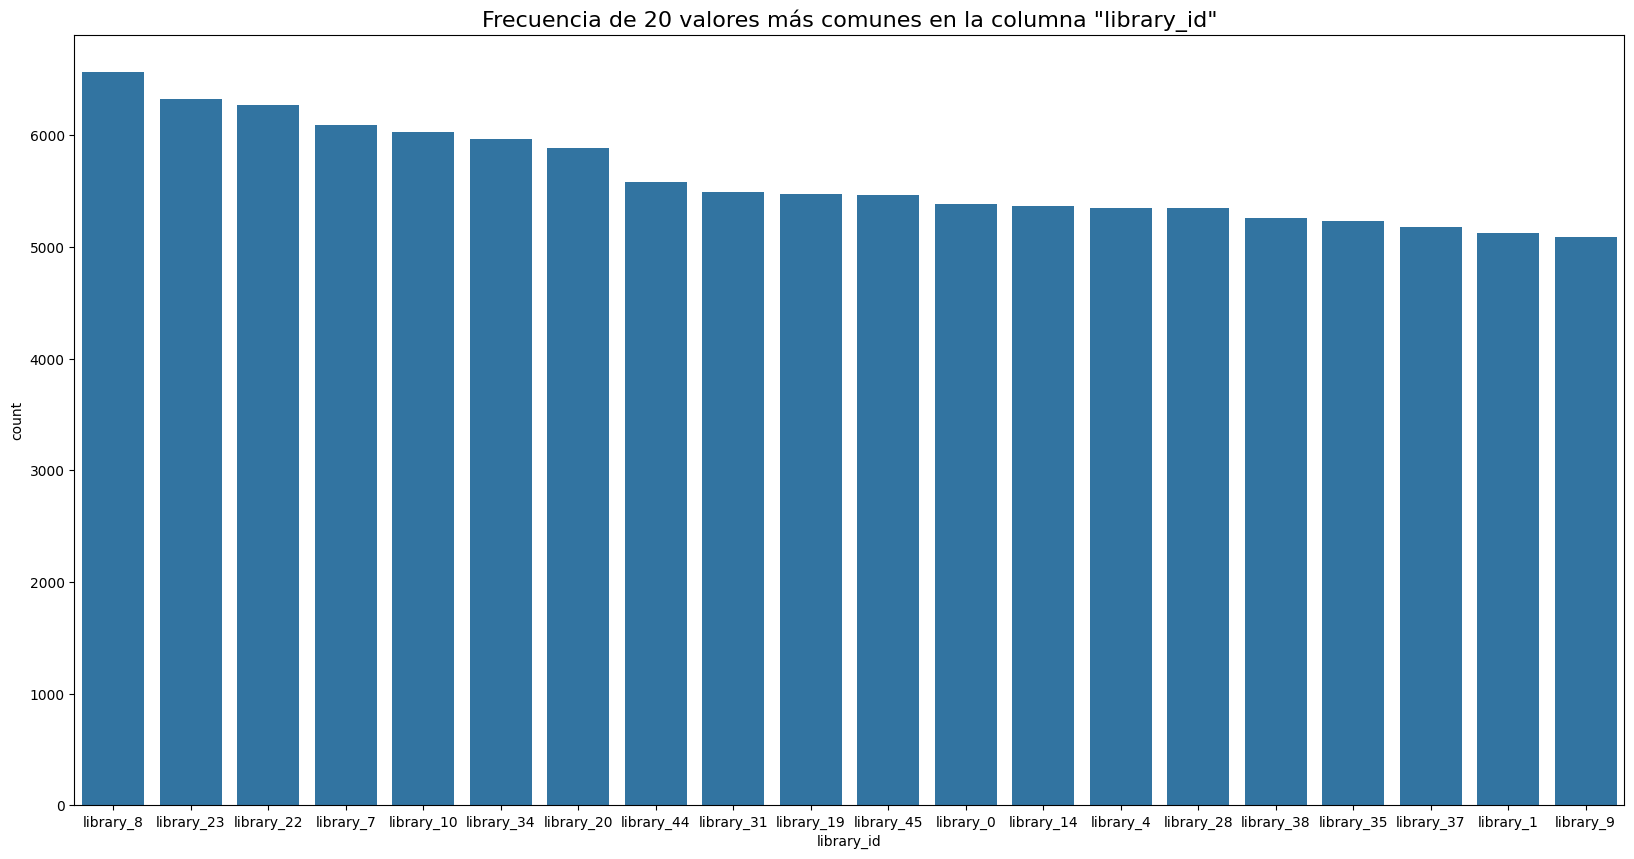

In [6]:
orderli = df_dataobs['library_id'].value_counts().sort_values(ascending=False).index
orderli_top20 = orderli[:20]
plt.figure(figsize=(20, 10))
sns.countplot(x='library_id', data=df_dataobs, order=orderli_top20)
plt.title('Frecuencia de 20 valores más comunes en la columna "library_id"', fontsize=16)
plt.show()

Aquí observamos la distribución de los datos en relación con la variable `library_id`, que identifica de manera única cada biblioteca. Este identificador corresponde a una medición realizada en muestras agrupadas por fila de la placa.

Se destaca que la biblioteca con mayor frecuencia es la número 8, seguida por la número 23. Estos dos identificadores de biblioteca presentan una frecuencia superior a 6,000 datos cada uno.

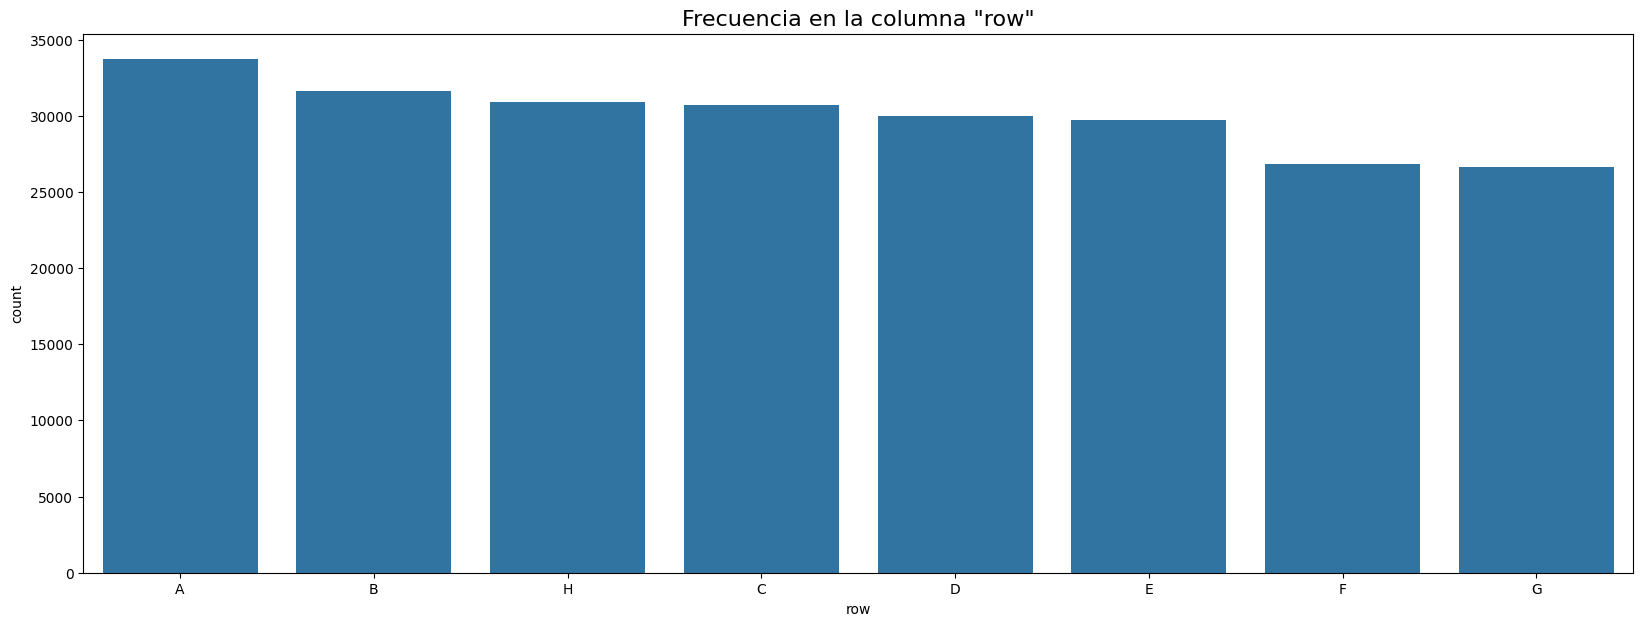

In [7]:
orderr = df_dataobs['row'].value_counts().sort_values(ascending=False).index
plt.figure(figsize=(20, 7))
sns.countplot(x='row', data=df_dataobs, order=orderr)
plt.title('Frecuencia en la columna "row"', fontsize=16)
plt.show()

In [8]:
print(df_dataobs['row'].value_counts())

row
A    33695
B    31636
H    30917
C    30701
D    29952
E    29747
F    26801
G    26641
Name: count, dtype: int64


**Análisis de la Distribución de row**

En el archivo `adata_obs_meta.csv`, la variable `row` que indica la fila de la placa presenta la siguiente distribución de muestras:

- **Fila A**: 33,695 muestras (la fila con mayor frecuencia)
- **Fila G**: 26,641 muestras.(La fila con menos muestras)

Este análisis revela un desequilibrio en la distribución de muestras entre las filas de la placa.


In [9]:
print(df_dataobs['cell_id'].value_counts())

cell_id
PBMC    240090
Name: count, dtype: int64


En la variable **`cell_id`**, todos los valores son **PBMC**, según la información proporcionada al principio.


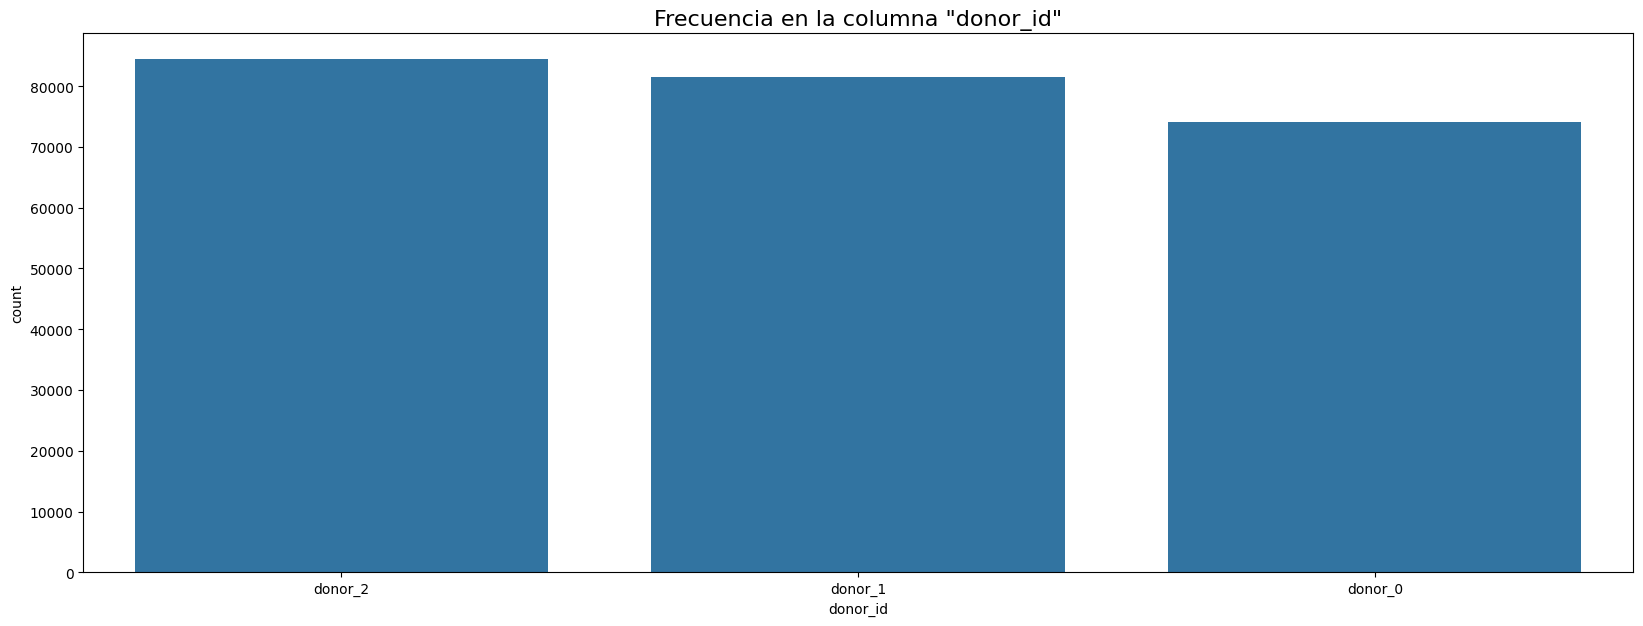

In [10]:
orderdon = df_dataobs['donor_id'].value_counts().sort_values(ascending=False).index
plt.figure(figsize=(20, 7))
sns.countplot(x='donor_id', data=df_dataobs, order=orderdon)
plt.title('Frecuencia en la columna "donor_id"', fontsize=16)
plt.show()

Observamos que la variable con mayor cantidad de datos es **`donor_id`**, indicando que la mayoría de los datos provienen de este donante. En contraste, la menor cantidad de datos proviene de **`donor_0`**.


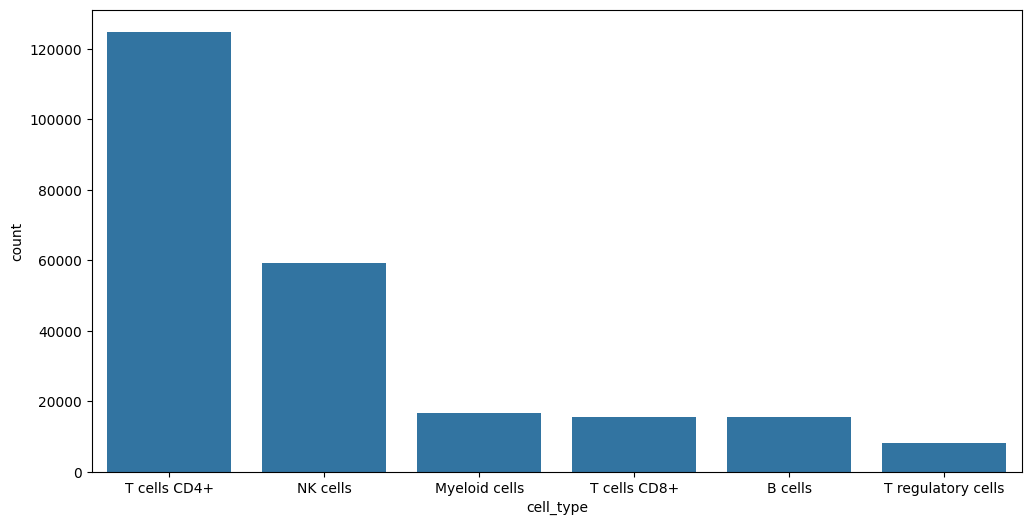

In [11]:
orderce = df_dataobs['cell_type'].value_counts().sort_values(ascending=False).index
plt.figure(figsize=(12, 6))
sns.countplot(x='cell_type', data=df_dataobs, order=orderce)
plt.show()


De los tipos de células, la categoría con mayor presencia es **"T cells CD4 +"**, que cuenta con más de 12,000 datos, siendo la de mayor proporción. En contraste, la categoría con menor presencia es **"T regulatory cells"**, la cual tiene la menor cantidad de datos, según las expresiones de ARN.


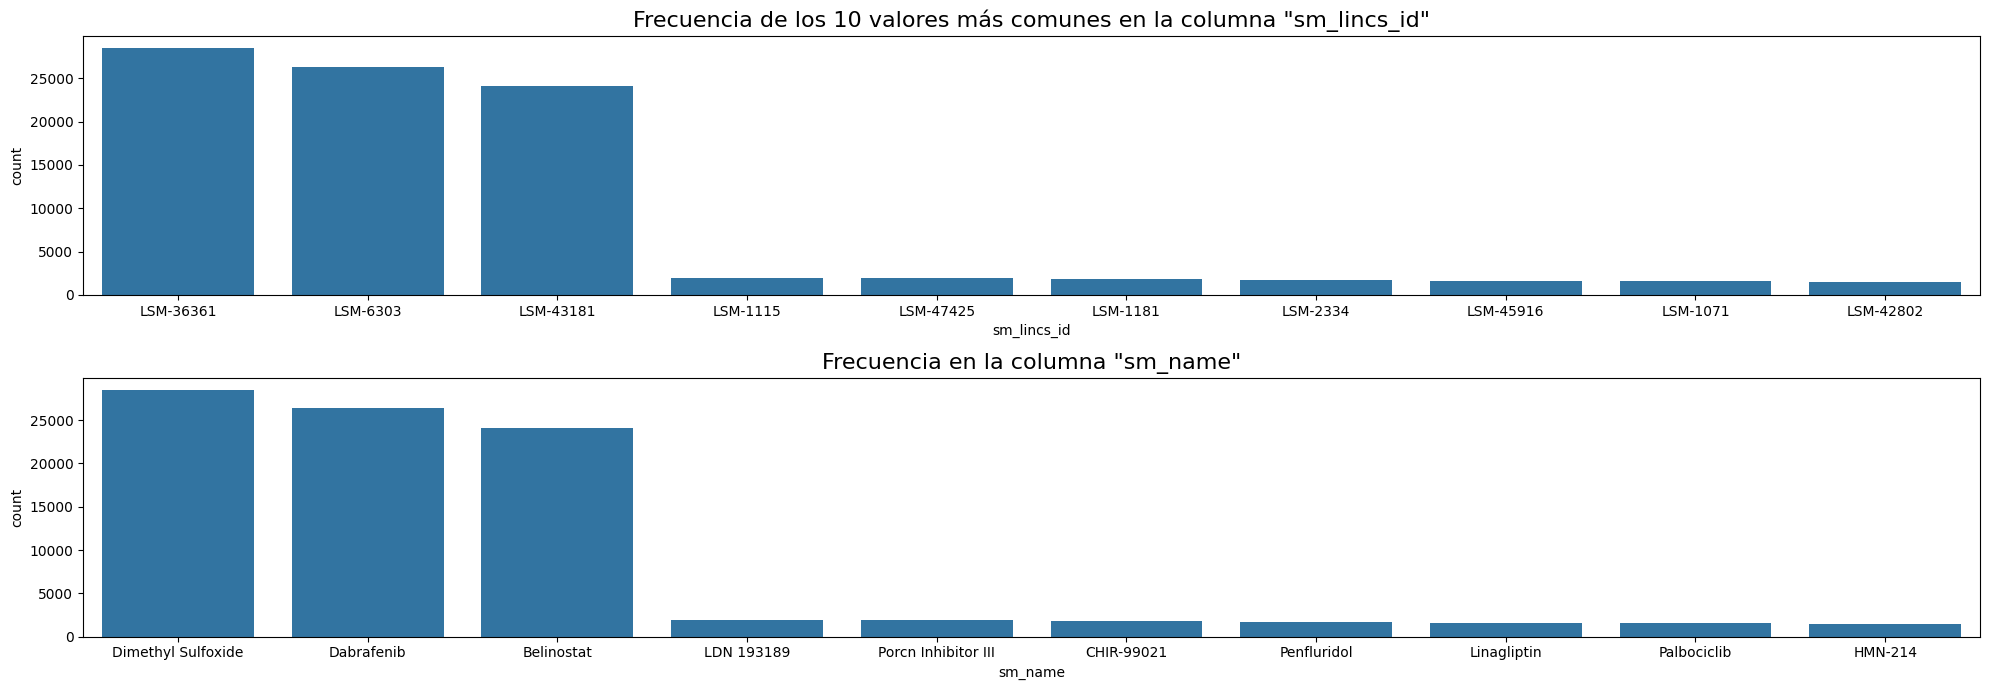

In [12]:
ordersm = df_dataobs['sm_lincs_id'].value_counts().sort_values(ascending=False).index
ordersm_top10 = ordersm[:10]

ordersma = df_dataobs['sm_name'].value_counts().sort_values(ascending=False).index
ordersma_top10 = ordersma[:10]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))

# Primer gráfico
sns.countplot(x='sm_lincs_id', data=df_dataobs, order=ordersm_top10, ax=ax1)
ax1.set_title('Frecuencia de los 10 valores más comunes en la columna "sm_lincs_id"', fontsize=16)

# Segundo gráfico
sns.countplot(x='sm_name', data=df_dataobs, order=ordersma_top10, ax=ax2)
ax2.set_title('Frecuencia en la columna "sm_name"', fontsize=16)

plt.tight_layout()
plt.show()

Aquí, en estas gráficas, se muestra el compuesto brindado por LINCS estandarizado. Los datos indican que los compuestos con mayores componentes son **"LSM-36361"**, **"LSM-6303"** y **"LSM-43181"**. En la parte inferior, se encuentra el nombre correspondiente a cada compuesto.


In [13]:
print('Las 10 mayores frecuencias en la columna SMILES')
print('-----------------------------------------------------------')
frequency_table = df_dataobs['SMILES'].value_counts().sort_values(ascending=False).head(10)
print(frequency_table)


Las 10 mayores frecuencias en la columna SMILES
-----------------------------------------------------------
SMILES
C[S+](C)[O-]                                                         28462
CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1    26346
O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO                             24059
c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)ccnc2c1                   1939
O=C(CSc1nc2c(c(=O)n1-c1ccccc1)SCC2)Nc1ccc(-c2ccccc2)cn1               1900
Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)cc2Cl)[nH]1              1798
OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1       1744
CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C     1600
CC(=O)c1c(C)c2cnc(Nc3ccc(N4CCNCC4)cn3)nc2n(C2CCCC2)c1=O               1573
COc1ccc(S(=O)(=O)N(C(C)=O)c2ccccc2/C=C/c2cc[n+]([O-])cc2)cc1          1514
Name: count, dtype: int64


Observamos en esta tabla las representaciones simplificadas del sistema de entrada de línea molecular (SMILES) de los compuestos, donde se encuentran ubicados con mayor frecuencia. A continuación, se muestran los 10 principales.

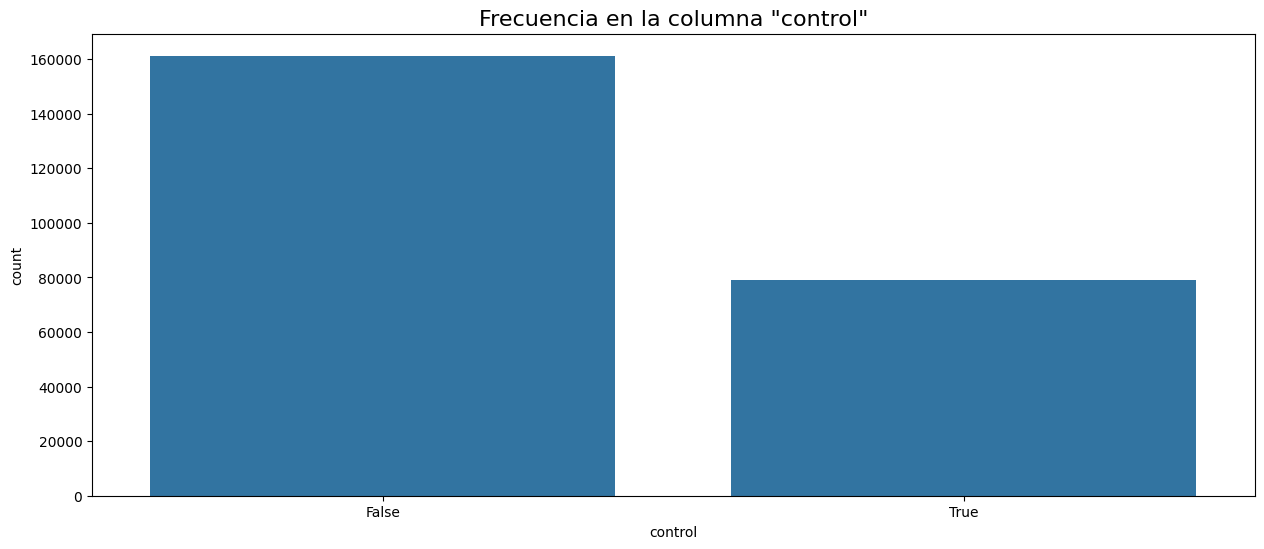

In [14]:
plt.figure(figsize=(15, 6))
sns.countplot(x='control', data=df_dataobs)
plt.title('Frecuencia en la columna "control"', fontsize=16)
plt.show()

Aquí se nos indica la proporción de control: esta variable indica si una observación se utilizó como control, con valores de Verdadero o Falso. La mayoría de los datos no fueron controlados, con aproximadamente 160,000 registros, lo que muestra una diferencia significativa en comparación con aquellos que sí tuvieron control.


# Variables numéricas

In [15]:
summary_numeric = df_dataobs.describe()
print(summary_numeric)

                col        dose_uM  timepoint_hr
count  240090.00000  240090.000000      240090.0
mean        6.05665       2.462781          24.0
std         3.55246       4.276144           0.0
min         1.00000       0.100000          24.0
25%         3.00000       1.000000          24.0
50%         6.00000       1.000000          24.0
75%         9.00000       1.000000          24.0
max        12.00000      14.100000          24.0


Se presenta un análisis general de las variables numéricas `col`, `dose_uM`, y `timepoint_hr` con los siguientes resultados:

En el análisis, se observa que la variable `col` varía entre 1 y 12, con una media de 6.06 y una desviación estándar de 3.55. La dosis `dose_uM` tiene un rango entre 1.00 y 12.00 micromolares, con una media de 6.06 y una desviación estándar de 3.55. Para la variable `timepoint_hr`, los valores oscilan entre 24.0 horas, con una media de 24.0 y una desviación estándar de 0.0. ya que se tomaron los datos en mismo intervalo de tiempo para todos los datos.


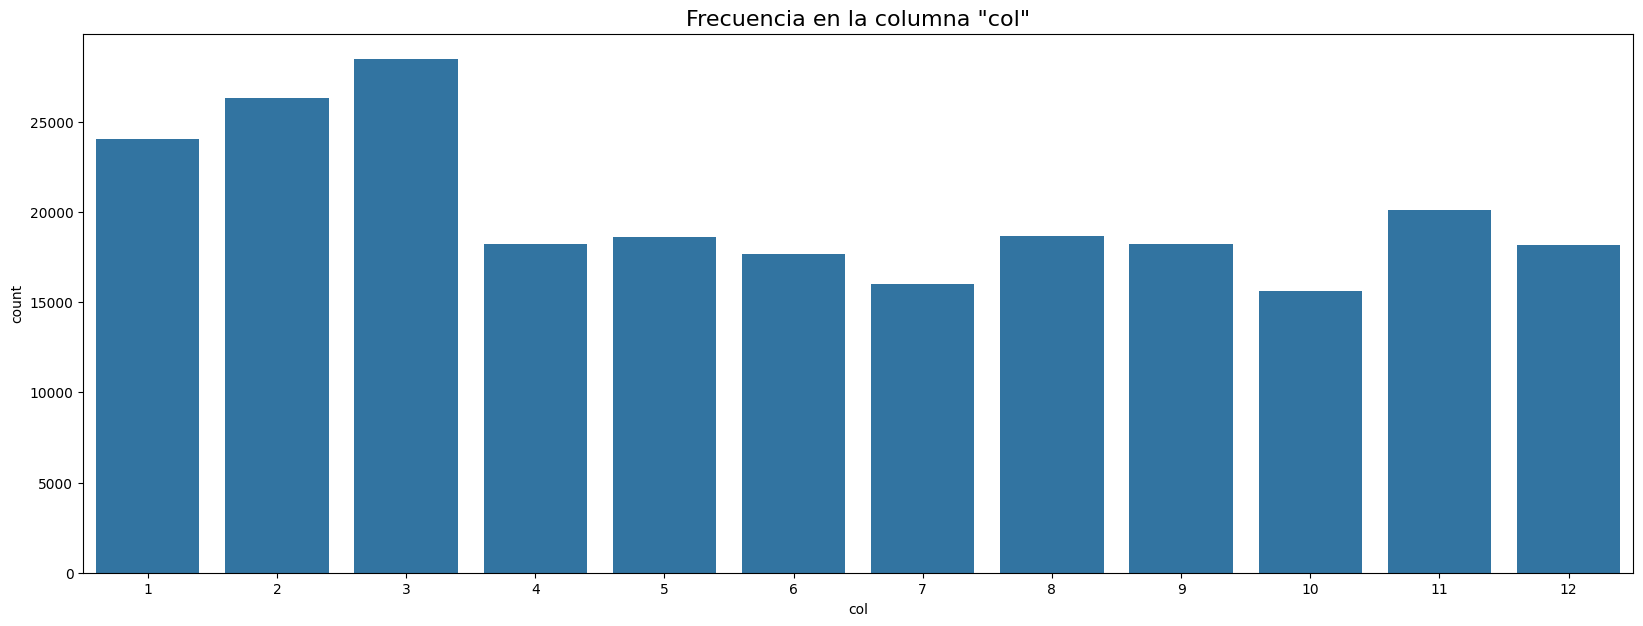

In [16]:
plt.figure(figsize=(20, 7))
sns.countplot(x='col', data=df_dataobs)
plt.title('Frecuencia en la columna "col"', fontsize=16)
plt.show()

La columna de la placa con mayor cantidad de datos fue la #3, mientras que las columnas con menos datos fueron la #7 y la #10. Estas últimas fueron las que tuvieron la menor cantidad de muestras en las placas.


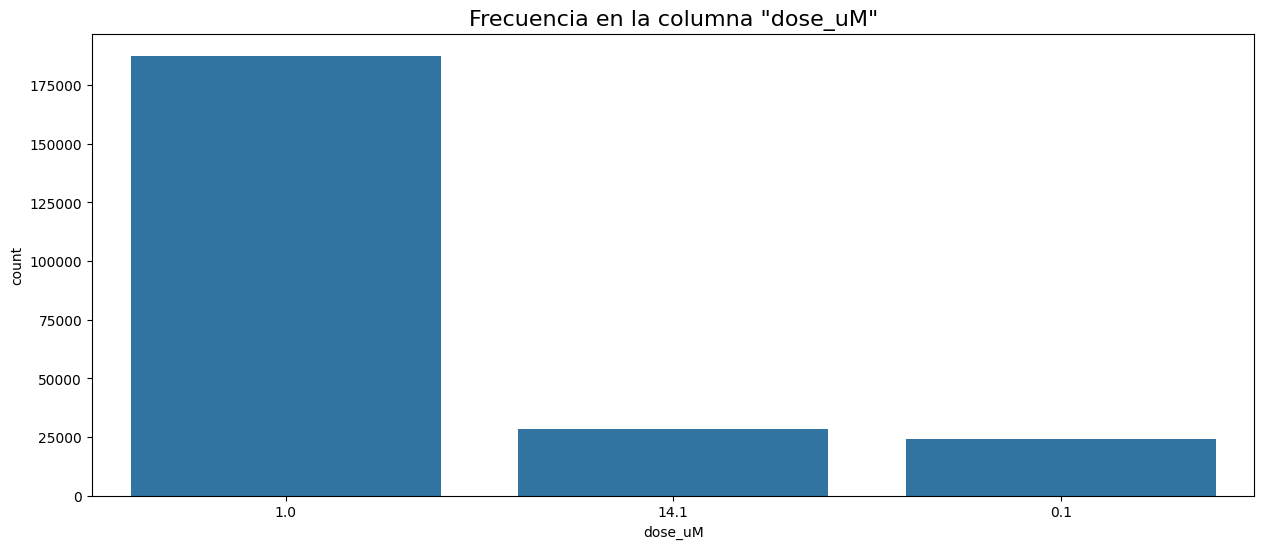

In [17]:
orderdose = df_dataobs['dose_uM'].value_counts().sort_values(ascending=False).index
plt.figure(figsize=(15, 6))
sns.countplot(x='dose_uM', data=df_dataobs, order=orderdose)
plt.title('Frecuencia en la columna "dose_uM"', fontsize=16)
plt.show()

La dosis del compuesto en escala micromolar con la mayor cantidad de datos fue "1.0", con aproximadamente más de 175,000 muestras, mientras que la menor dosis fue "0.1", cercana a "14.1".

## Análisis de NA'S

In [18]:
df_dataobs.isnull().sum()

obs_id          0
library_id      0
plate_name      0
well            0
row             0
col             0
cell_id         0
donor_id        0
cell_type       0
sm_lincs_id     0
sm_name         0
SMILES          0
dose_uM         0
timepoint_hr    0
control         0
dtype: int64

**Análisis de Valores NA en el Conjunto de Datos**

En el conjunto de datos, se observa que ninguna de las columnas presenta valores faltanteS. Esto significa que todas las columnas, incluyendo obs_id, library_id, plate_name, well, row, col, cell_id, donor_id, cell_type, sm_lincs_id, sm_name, SMILES, dose_uM, timepoint_hr, y control, están completamente completas.



# Data frame de "id_map"

In [19]:
df_map.tail()

,id,cell_type,sm_name
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat
254,254,Myeloid cells,YK 4-279


### Descripción del Archivo `id_map.csv`

- **`id`**: Identificador único para cada entrada en el archivo.
  
- **`cell_type`**: Tipo de célula que se debe predecir para el identificador dado. Este campo especifica el tipo de célula asociado con el `id`.
  
- **`sm_name`**: Nombre del compuesto que se debe predecir para el identificador dado. Este campo indica el nombre del compuesto relacionado con el `id`.

*Información proporcionada por Kaggle para el ejercicio.*

In [20]:
print(df_map.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         255 non-null    int64 
 1   cell_type  255 non-null    object
 2   sm_name    255 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.1+ KB
None


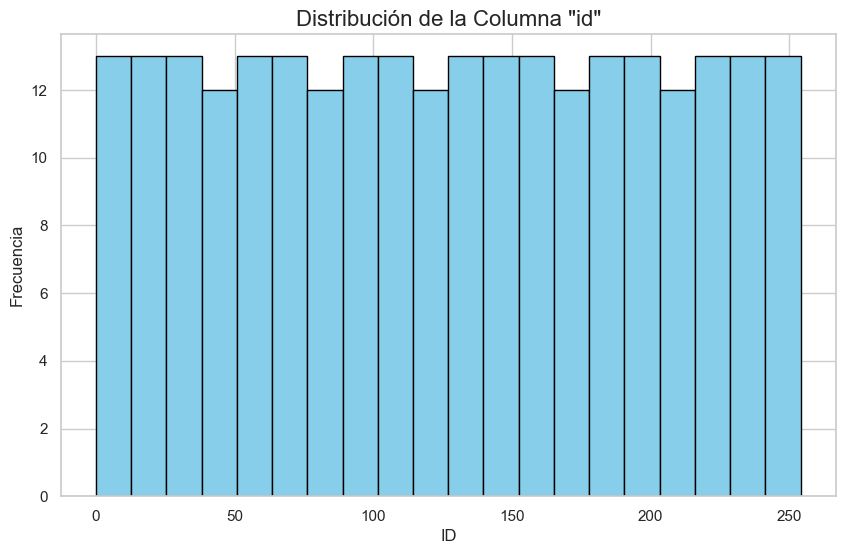

C:\Users\loren\AppData\Local\Temp\ipykernel_12532\3103301280.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cell_type', data=df_map, palette='viridis')


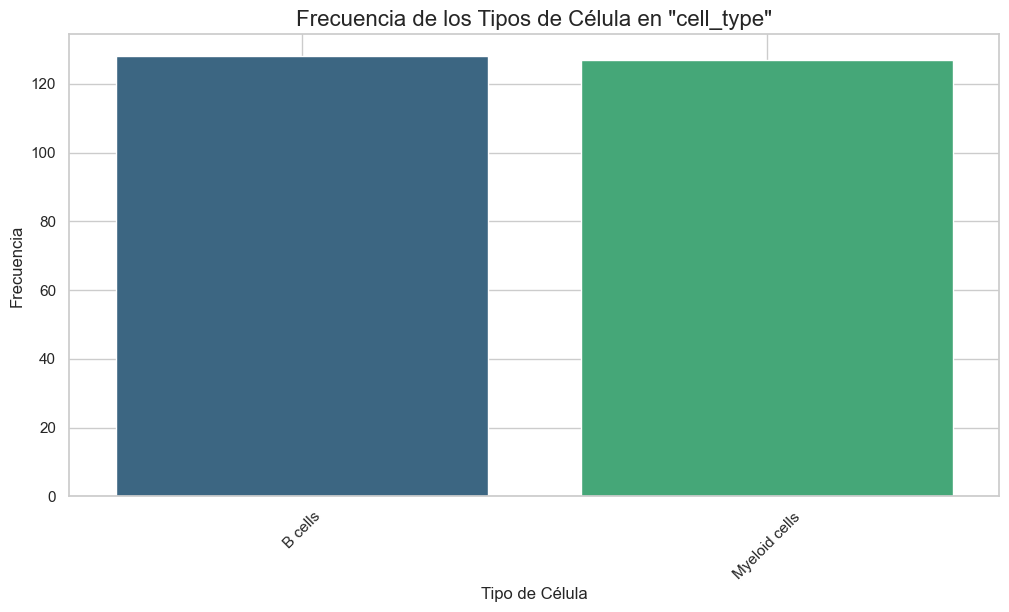

In [21]:
sns.set(style="whitegrid")

# 1. Gráfico para la columna 'id'
plt.figure(figsize=(10, 6))
plt.hist(df_map['id'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Columna "id"', fontsize=16)
plt.xlabel('ID')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# 2. Gráfico para la columna 'cell_type'
plt.figure(figsize=(12, 6))
sns.countplot(x='cell_type', data=df_map, palette='viridis')
plt.title('Frecuencia de los Tipos de Célula en "cell_type"', fontsize=16)
plt.xlabel('Tipo de Célula')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





### Análisis de Gráficas

Observamos que en el histograma de "id" se presenta una concentración bastante uniforme para la mayoría de los datos. Sin embargo, hay algunos identificadores que tienen una frecuencia ligeramente menor que el resto.

En la gráfica siguiente, se nota que existe una proporción casi igual para los tipos de células en ambos tipos que presenta la base de datos, siendo esta alrededor de 120 datos.



C:\Users\loren\AppData\Local\Temp\ipykernel_12532\1065589472.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sm_name', data=df_top_30, palette='viridis', order=top_30_sm_names)


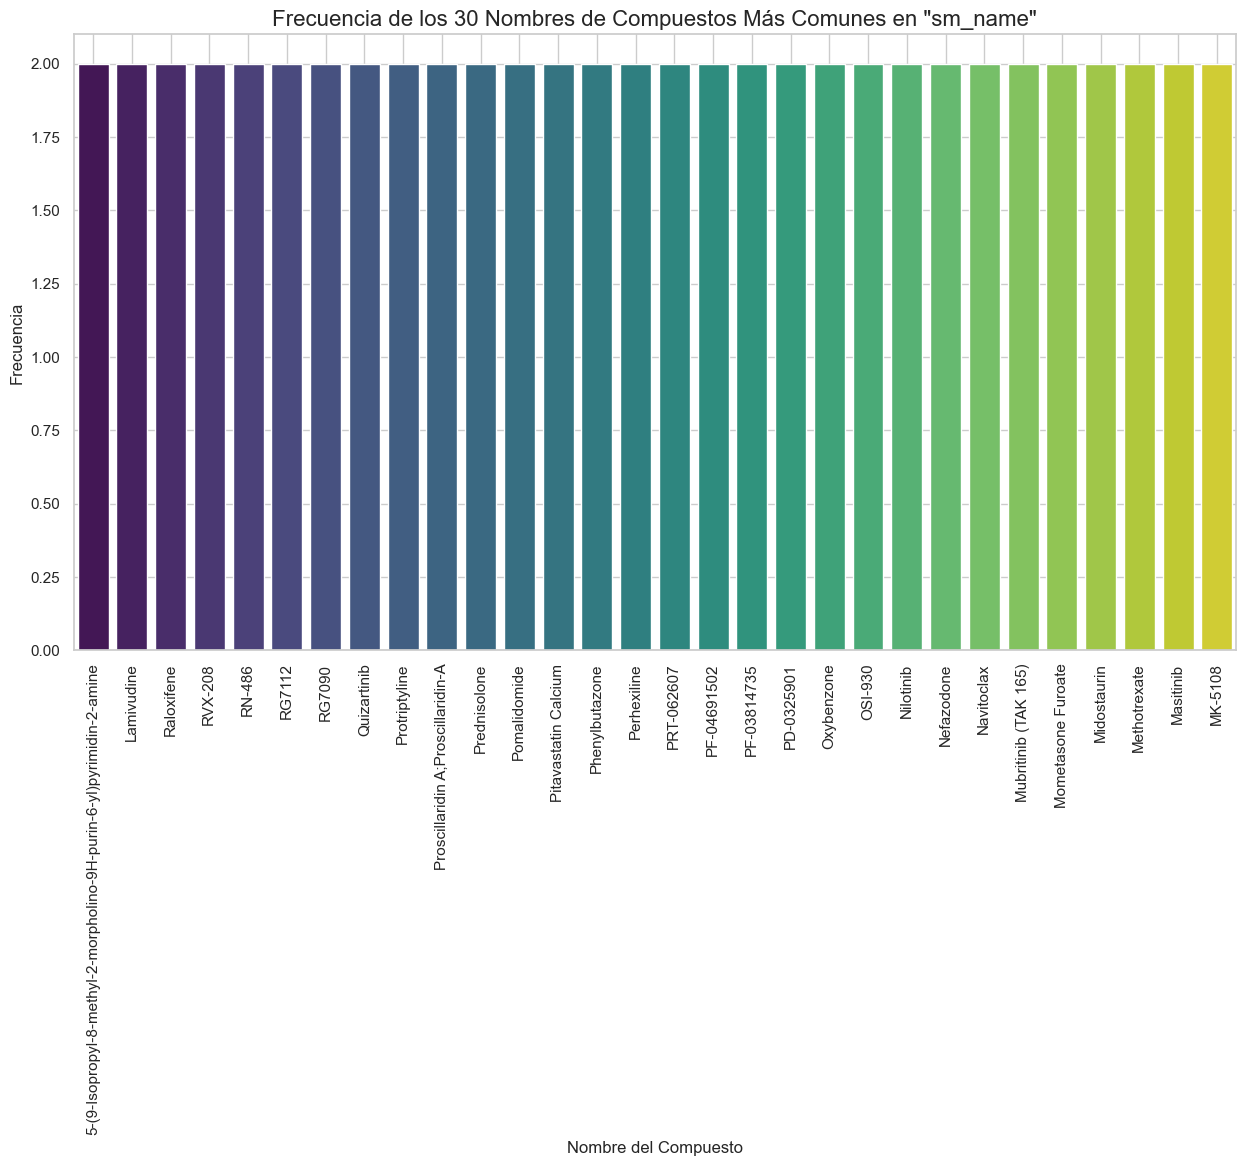

In [22]:
# Supongamos que has cargado tu DataFrame desde 'id_map.csv'
df = pd.read_csv('documentos_ejercicio2.2\\id_map.csv')

# Contar las frecuencias de cada valor en la columna 'sm_name'
sm_name_counts = df['sm_name'].value_counts()

# Seleccionar los primeros 30 valores más frecuentes
top_30_sm_names = sm_name_counts.head(30).index

# Filtrar el DataFrame para solo incluir los valores seleccionados
df_top_30 = df[df['sm_name'].isin(top_30_sm_names)]

# Crear el gráfico
plt.figure(figsize=(15, 8))
sns.countplot(x='sm_name', data=df_top_30, palette='viridis', order=top_30_sm_names)
plt.title('Frecuencia de los 30 Nombres de Compuestos Más Comunes en "sm_name"', fontsize=16)
plt.xlabel('Nombre del Compuesto')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para una mejor legibilidad
plt.grid(True)
plt.show()


Aquí observamos que los compuestos que se presentan con mayor frecuencia son los que se muestran en las gráficas, indicando que en estas variables está la mayor proporción.


## Análisis de NA'S

In [23]:
print("\nValores Faltantes en el DataFrame:")
print(df_map.isna().sum())


Valores Faltantes en el DataFrame:
id           0
cell_type    0
sm_name      0
dtype: int64


Observamos además que no existen datos NA, siendo todos los datos de las variables completos.


# Data frame de "de_train"

In [24]:
df_parqdtra.tail()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112
613,T regulatory cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.757116,0.085910,-0.730025,-1.367801,-0.695944,...,0.232343,-2.247816,-0.346036,-0.919567,-1.131372,-0.120252,-0.064537,-0.603280,-0.098041,-0.750681


## Descripción del Archivo `de_train.parquet`

- **`de_train.parquet`**: Contiene datos de expresión diferencial en formato de matriz densa.

1. **Genes**:
   - **Ejemplo**: `A1BG`, `A1BG-AS1`, …, `ZZEF1`
   - **Total**: 18.211 genes
   - **Valor de expresión diferencial**: Calculado como `-log10(p-value) * sign(LFC)`. Aquí, `LFC` es el cambio estimado en el logaritmo de la expresión entre la condición de tratamiento y la de control. Un `LFC` positivo indica que el gen aumenta en la condición de tratamiento en comparación con el control.

2. **`cell_type`**:
   - **Descripción**: Tipo de célula anotado para cada célula basado en la expresión de ARN.

3. **`sm_name`**:
   - **Descripción**: Nombre principal del compuesto (en una representación estandarizada) elegido por LINCS. Esto se proporciona para mapear los datos de este experimento con los datos del Mapa de conectividad de LINCS.

4. **`sm_lincs_id`**:
   - **Descripción**: ID global de LINCS (principal) compuesto (en una representación estandarizada). Se utiliza para mapear los datos de este experimento a los datos del Mapa de conectividad de LINCS.

5. **`SMILES`**:
   - **Descripción**: Representaciones simplificadas del sistema de entrada de línea molecular (SMILES) de los compuestos utilizados en el experimento. Es una representación unidimensional de la estructura molecular proporcionada por Cellarity.

6. **`control`**:
   - **Descripción**: Booleano que indica si esta instancia se utilizó como control.

#### Objetivo del Proyecto:

El archivo `de_train.parquet` incluye los datos principales. Contiene valores para una serie de pares `cell_type`/`sm_name`. El objetivo es predecir los valores correspondientes para los pares `cell_type`/`sm_name` indicados en `id_map.csv`.

**Nota**: No hay datos de expresión diferencial para la muestra de DMSO, ya que se utiliza como control negativo. Todos los resultados de expresión diferencial se calculan en referencia al DMSO, es decir, el análisis de expresión diferencial investiga "¿qué tan seguro estoy de que cada gen aumentó o disminuyó en relación con el DMSO debido al tratamiento con el compuesto?".

*Información proporcionada por Kaggle para el ejercicio.*

predecir cambios en la expresion genica segun compuesta y tipo de celula que se le aplica

In [25]:
df_parqdtra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Columns: 18216 entries, cell_type to ZZEF1
dtypes: bool(1), float64(18211), object(4)
memory usage: 85.3+ MB


## Análisis de datos NA'S

In [26]:
print(df_parqdtra.isna().sum())


cell_type      0
sm_name        0
sm_lincs_id    0
SMILES         0
control        0
              ..
ZXDB           0
ZXDC           0
ZYG11B         0
ZYX            0
ZZEF1          0
Length: 18216, dtype: int64


Antes de iniciar con el EDA, observamos que ninguna columna tiene datos NA, lo cual es un buen indicio, ya que el DataFrame está completo, al igual que los anteriores.


## Análisis de Variables Categóricas

C:\Users\loren\AppData\Local\Temp\ipykernel_12532\3530360793.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cell_type', data=df_parqdtra, palette='viridis')


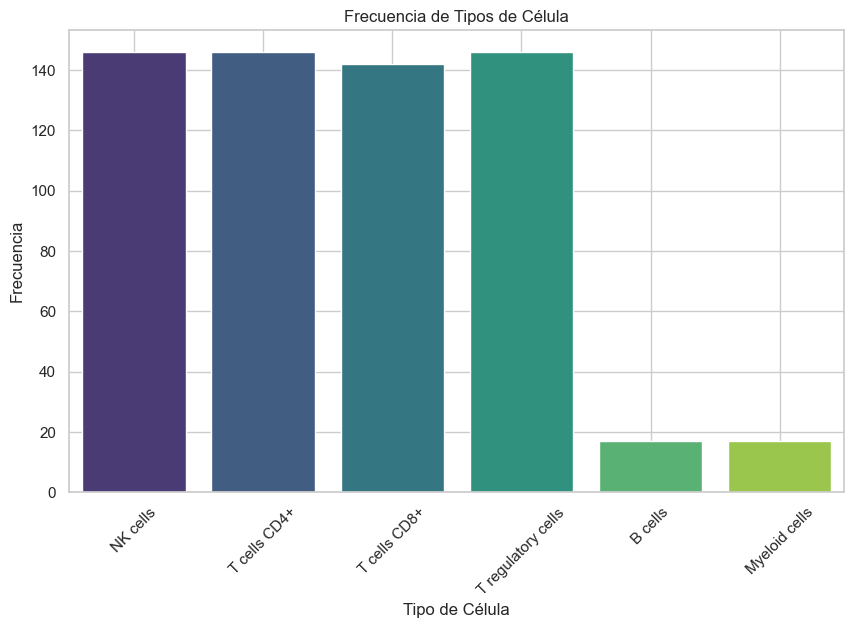

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cell_type', data=df_parqdtra, palette='viridis')
plt.title('Frecuencia de Tipos de Célula')
plt.xlabel('Tipo de Célula')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


En esta gráfica se presenta la mayor frecuencia de los tipos de células, mostrando que "NK cells" es el tipo con mayor frecuencia, seguido muy de cerca por "T cells CD4+", "T cells CD8+" y "T regulatory cells". Los tipos restantes tienen frecuencias muy similares.


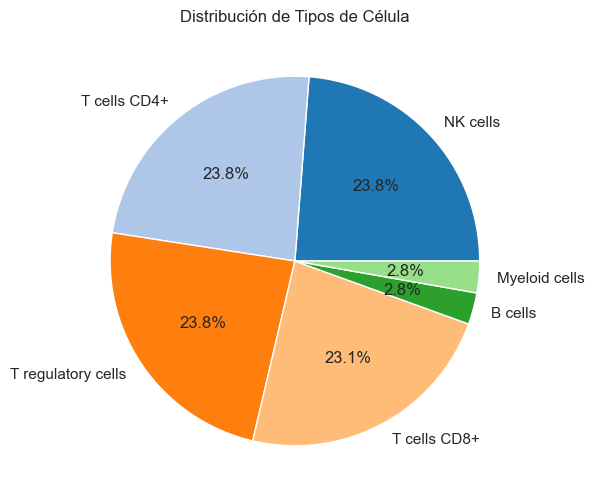

In [28]:
cell_type_counts = df_parqdtra['cell_type'].value_counts()
colors = plt.get_cmap('tab20').colors

# Crea el gráfico circular
plt.figure(figsize=(10, 6))
plt.pie(cell_type_counts, labels=cell_type_counts.index, autopct='%1.1f%%', colors=colors[:len(cell_type_counts)])
plt.title('Distribución de Tipos de Célula')
plt.show()



### Análisis de la Proporción

Se observa la distribución de la proporción de los datos del tipo de célula, información relacionada con la anterior. La proporción es casi igual para "T cells CD4+", "NK cells" y "T regulatory cells", siendo estos los tipos de células con mayor porcentaje. Por otro lado, "B cells" y "Myeloid cells" tienen las proporciones más bajas, de manera similar.



C:\Users\loren\AppData\Local\Temp\ipykernel_12532\511625904.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='control', data=df_parqdtra, palette='viridis')


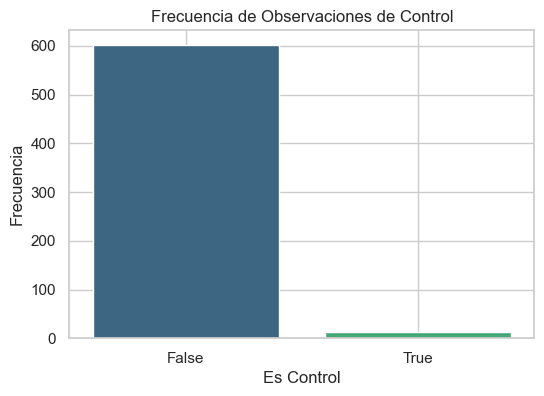

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x='control', data=df_parqdtra, palette='viridis')
plt.title('Frecuencia de Observaciones de Control')
plt.xlabel('Es Control')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


Esta gráfica proporciona un análisis sobre si los datos tuvieron un control o no. Se aprecia que la mayoría de los datos no fueron controlados, con una gran proporción sin control (alrededor de 600 datos), mientras que los datos con control son muy bajos.


In [30]:
print('Las frecuencias en la columna SMILES')
print('-----------------------------------------------------------')
print(df_parqdtra['SMILES'].value_counts().sort_values(ascending=False))

Las frecuencias en la columna SMILES
-----------------------------------------------------------
SMILES
Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1cc2c(nn1)-c1ccccc1CCC2                                 6
Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21                                    6
c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)ccnc2c1                                                 6
O=C(CSc1nc2c(c(=O)n1-c1ccccc1)SCC2)Nc1ccc(-c2ccccc2)cn1                                             6
O=C(O)c1ccc2cc(-c3ccc(O)c(C45CC6CC(CC(C6)C4)C5)c3)ccc2c1                                            6
                                                                                                   ..
CN1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1                                                       4
Cc1nc2c(-c3cnc(N)nc3)nc(N3CCOCC3)nc2n1C(C)C                                                         4
COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(N(C)C[C@H]3CC[C@H](N4CCN(C)C(=O)C4

En esta tabla se observan las representaciones simplificadas del sistema de entrada de línea molecular (SMILES). Vemos las que ocupan los primeros lugares y las que se ubican al final.


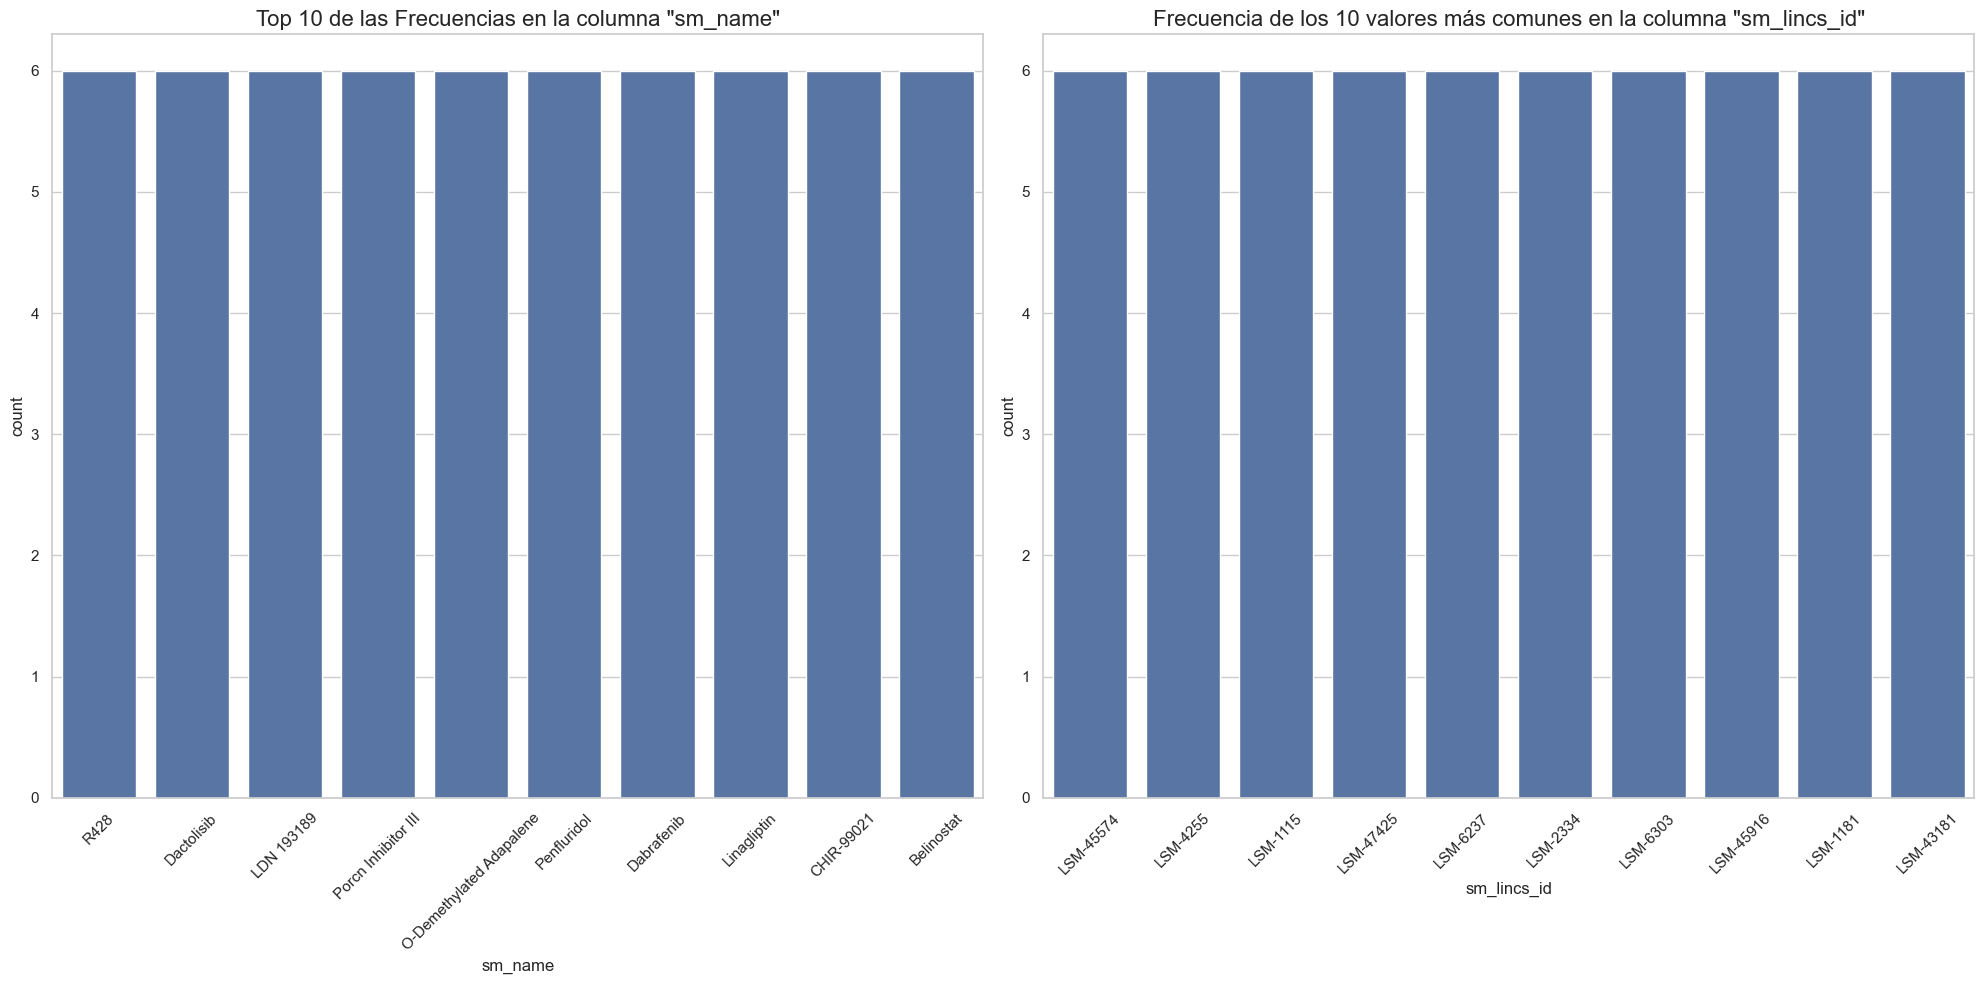

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

ordersma = df_parqdtra['sm_name'].value_counts().sort_values(ascending=False).index
ordersma_top10 = ordersma[:10]
ordersm = df_parqdtra['sm_lincs_id'].value_counts().sort_values(ascending=False).index
ordersm_top10 = ordersm[:10]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)  
sns.countplot(x='sm_name', data=df_parqdtra, order=ordersma_top10)
plt.title('Top 10 de las Frecuencias en la columna "sm_name"', fontsize=16)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)  
sns.countplot(x='sm_lincs_id', data=df_parqdtra, order=ordersm_top10)
plt.title('Frecuencia de los 10 valores más comunes en la columna "sm_lincs_id"', fontsize=16)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


En estas gráficas se observa el nombre principal del compuesto y el ID del compuesto. Se puede ver que los compuestos con mayor proporción son "R428" y "Dactolisib", con IDs de "LSM-45574" y "LSM-4255", respectivamente. Estos compuestos están ubicados en los primeros dos puestos, aunque tienen una proporción similar a la de los demás compuestos mostrados en las gráficas.



## Análisis de Variables Numéricas

Nuestras variables numéricas son las mismas que las de respuesta.



### Variable respuesta

In [32]:
print(df_parqdtra['cell_type'].value_counts())

cell_type
NK cells              146
T cells CD4+          146
T regulatory cells    146
T cells CD8+          142
B cells                17
Myeloid cells          17
Name: count, dtype: int64



Aquí observamos la frecuencia de nuestra variable objetivo y vemos que las que tienen mayor frecuencia son:

- **NK cells**: 146
- **T cells CD4+**: 146
- **T regulatory cells**: 146













# Análisis de datos atípicos

In [33]:
df_numeric = df_parqdtra.select_dtypes(include=[float, int])


In [34]:
# Seleccionar solo columnas numéricas
df_numeric = df_parqdtra.select_dtypes(include=['float64', 'int64'])

# Calcular los percentiles de una sola vez para todas las columnas
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers en todas las columnas a la vez
outliers_condition = (df_numeric < lower_bound) | (df_numeric > upper_bound)

# Contar los outliers por columna
outliers_summary = outliers_condition.sum().to_dict()

# Convertir el diccionario a un DataFrame para visualización
outliers_df = pd.DataFrame(list(outliers_summary.items()), columns=['Variable', 'Outliers'])
outliers_df = outliers_df.sort_values(by='Outliers', ascending=False)

# Mostrar los primeros 10 resultados en formato tabular
print(tabulate(outliers_df.head(10), headers='keys', tablefmt='pipe'))


|       | Variable   |   Outliers |
|------:|:-----------|-----------:|
|  7389 | FTH1       |        123 |
|  7397 | FTL        |        107 |
|  5980 | DDX5       |        105 |
| 16761 | TXNIP      |        105 |
|  7984 | H1FX       |        104 |
|  6550 | EIF4A2     |         98 |
|  5786 | CXCR4      |         97 |
|  8035 | HBB        |         97 |
|  4925 | CD7        |         97 |
|  8171 | HIST1H1D   |         96 |


### Análisis de datos:

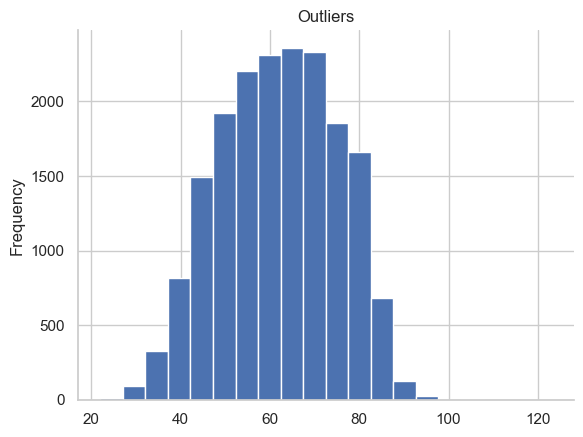

In [35]:
outliers_df['Outliers'].plot(kind='hist', bins=20, title='Outliers')
plt.gca().spines[['top', 'right',]].set_visible(False)

Observamos la distribución de los datos atípicos en nuestras variables de genes y cómo se distribuyen, indicando que hay una mayor concentración de la mayoría de los datos alrededor de 60 datos atípicos en las variables de genes.


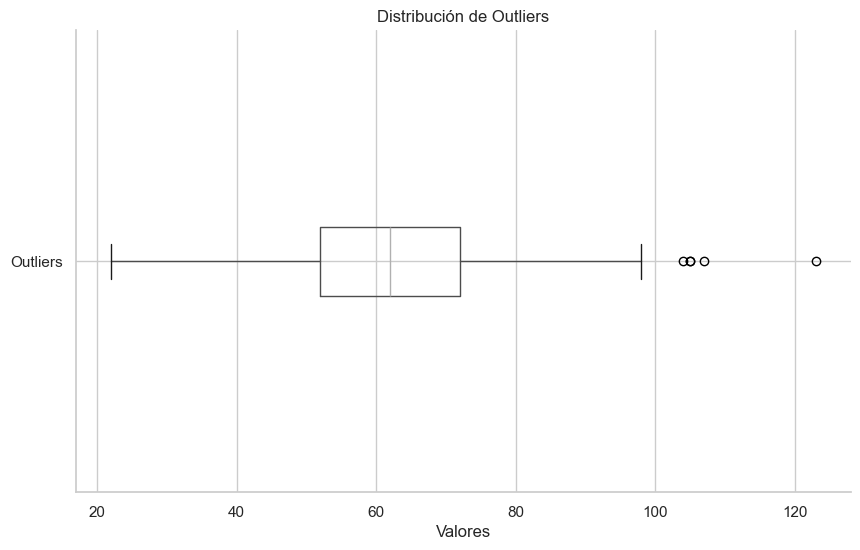

In [36]:
# Crear un boxplot para visualizar los outliers
plt.figure(figsize=(10, 6))
outliers_df.boxplot(column='Outliers', vert=False)  # Cambia 'Outliers' por la columna relevante en tu DataFrame
plt.title('Distribución de Outliers')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Valores')
plt.show()


Observamos en este **boxplot** cómo se distribuyen los datos, indicando que dentro de los datos atípicos de nuestras variables de genes también existen algunos datos con una alta cantidad de valores atípicos. Estos datos atípicos están claramente representados en el boxplot, confirmando lo que mencionamos en el análisis anterior.


# Reducion de dimensionalidad

In [37]:
# Ajustar el selector al DataFrame original
selector = VarianceThreshold(threshold=0.1)  # Umbral de varianza
selector.fit(df_numeric)

# Obtener las columnas que se mantuvieron después de la selección
columns_selected = df_numeric.columns[selector.get_support(indices=True)]

# Mostrar las columnas eliminadas
columns_eliminated = df_numeric.columns.difference(columns_selected)

print("Columnas eliminadas debido a baja varianza:")
print(columns_eliminated)


Columnas eliminadas debido a baja varianza:
Index([], dtype='object')


**Análisis de la Reducción de Dimensionalidad**

En el resultado obtenido, se muestra que al intentar reducir la dimensionalidad del DataFrame, ninguna variable fue eliminada. Esto indica que no se eliminó ninguna columna debido a la baja varianza, ya que la lista de columnas eliminadas está vacía (Index([], dtype='object')).
